### Проект по предсказанию энергоэффективности зданий Нью-Йорка

#### Описание задачи

Данные: энергоэффективность зданий в Нью-Йорке. (https://www1.nyc.gov/html/gbee/html/plan/ll84_scores.shtml)

Цель: использовать имеющиеся данные для построения модели, которая прогнозирует количество баллов Energy Star Score для конкретного здания, и интерпретировать результаты для поиска факторов, влияющих на итоговый балл.

Данные уже включают в себя присвоенные баллы Energy Star Score, поэтому задача - обучение с учителем, регрессия, где балл Energy Star Score — это непрерывная переменная.

#### Этапы

* Очистка и форматирование данных;
* Разведочный анализ данных;
* Конструирование и выбор признаков;
* Сравнение метрик нескольких моделей машинного обучения;
* Гиперпараметрическая настройка лучшей модели;
* Оценка лучшей модели на тестовом наборе данных;
* Интерпретирование результатов работы модели;
* Выводы и работа с документами.

#### Очистка данных

In [216]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [25]:
# Read in data into a dataframe 
data = pd.read_excel('https://www1.nyc.gov/html/gbee/downloads/excel/nyc_benchmarking_disclosure_2017_consumption_data.xlsx',
                     sheet_name='Information and Metrics')

# Display top of dataframe
data.head()

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2 (self-reported),...,Annual Maximum Demand (kW),Annual Maximum Demand (MM/YYYY),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Water Use (All Water Sources) (kgal),Water Use Intensity (All Water Sources) (gal/ft²),Water Required?,Generation Date,DOF Benchmarking Submission Status
0,1,4593574,The Argonaut Building,NaN,NaN,1.010288e+09,1010287502,1024898,224 West 57th St,NaN,...,NaN,NaT,732.4,76.3,656.1,3635.5,21.46,Not found,2018-02-14,Not found
1,3,2967701,Cathedral Preparatory Seminary,NaN,NaN,4.018720e+09,4-01872-0007,4046340,56-25 92nd Street,NaN,...,NaN,NaT,164.5,109.9,54.6,102.9,1.09,Not found,2018-02-14,Not found
2,4,4898531,The Nomad Hotel,NaN,NaN,1.008290e+09,1-00829-0050,1080710,1170 Broadway,NaN,...,NaN,NaT,1150.2,438.0,712.3,10762.6,86.10,Not found,2018-02-14,Not found
3,5,2917939,10 West 27 Street Corp,NaN,NaN,1.008280e+09,1-00828-0053,1015657,1155 Broadway,NaN,...,NaN,NaT,273.4,98.2,175.3,790.1,15.80,Not found,2018-02-14,Not found
4,6,3878205,Westbury Realty,NaN,NaN,1.000650e+09,1-00065-0024,1001105,24 John Street,NaN,...,NaN,NaT,90.7,0.0,90.7,143.0,2.86,Not found,2018-02-14,Not found


In [26]:
# See the column data types and non-missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34355 entries, 0 to 34354
Data columns (total 60 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   Order                                                       34355 non-null  int64         
 1   Property Id                                                 34355 non-null  int64         
 2   Property Name                                               34355 non-null  object        
 3   Parent Property Id                                          1723 non-null   object        
 4   Parent Property Name                                        1723 non-null   object        
 5   BBL - 10 digits                                             33625 non-null  float64       
 6   NYC Borough, Block and Lot (BBL) self-reported              33626 non-null  object        
 7   NYC Building Identific

Переведем object в float. Например, у признака 'DOF... (ft²)' тип данных object. Посмотрим, из чего состоит:

In [27]:
data['DOF Gross Floor Area (ft²)']

0        Not found
1        Not found
2        Not found
3        Not found
4        Not found
           ...    
34350    Not found
34351    Not found
34352    Not found
34353    Not found
34354    Not found
Name: DOF Gross Floor Area (ft²), Length: 34355, dtype: object

In [28]:
# Replace all occurrences of Not Available with numpy not a number
data = data.replace({'Not found': np.nan})

# Iterate through the columns
for col in list(data.columns):
    # Select columns that should be numeric
    if ('ft²' in col or 'kBtu' in col or 'Metric Tons CO2e' in col or 'kWh' in 
        col or 'therms' in col or 'gal' in col or 'Score' in col):
        # Convert the data type to float
        data[col] = data[col].astype(float)

In [29]:
# Отсутствующие и аномальные данные
# https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe/39734251#39734251

# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [30]:
missing_values_table(data)

Your selected dataframe has 60 columns.
There are 48 columns that have missing values.


,Missing Values,% of Total Values
DOF Benchmarking Submission Status,34355,100.0
Water Required?,34355,100.0
Street Number,34355,100.0
Street Name,34355,100.0
DOF Gross Floor Area (ft²),34355,100.0
Propane Use (kBtu),34354,100.0
District Hot Water Use (kBtu),34347,100.0
District Chilled Water Use (kBtu),34325,99.9
Fuel Oil #1 Use (kBtu),34319,99.9
Diesel #2 Use (kBtu),34285,99.8


Теоретически 25-30% - максимум разрешенных отсутствующих значений, которые можно дропнуть.
Здесь удалим колонки, пустые более чем на половину.

In [31]:
# Get the columns with > 50% missing
missing_df = missing_values_table(data);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50].index)
print('We will remove %d columns.' % len(missing_columns))

Your selected dataframe has 60 columns.
There are 48 columns that have missing values.
We will remove 24 columns.


In [32]:
# Drop the columns
data = data.drop(columns = list(missing_columns))

Удалим выбросы

In [63]:
# Calculate first and third quartile
first_quartile = data['Site EUI (kBtu/ft²)'].describe()['25%']
third_quartile = data['Site EUI (kBtu/ft²)'].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

# Remove outliers
data = data[(data['Site EUI (kBtu/ft²)'] > (first_quartile - 3 * iqr)) &
            (data['Site EUI (kBtu/ft²)'] < (third_quartile + 3 * iqr))]

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31104 entries, 0 to 34354
Data columns (total 36 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   Order                                                       31104 non-null  int64         
 1   Property Id                                                 31104 non-null  int64         
 2   Property Name                                               31104 non-null  object        
 3   BBL - 10 digits                                             30509 non-null  float64       
 4   NYC Borough, Block and Lot (BBL) self-reported              30510 non-null  object        
 5   NYC Building Identification Number (BIN)                    30099 non-null  object        
 6   Address 1 (self-reported)                                   31104 non-null  object        
 7   Postal Code           

#### Разведочный анализ данных

Text(0.5, 1.0, 'Energy Star Score Distribution')

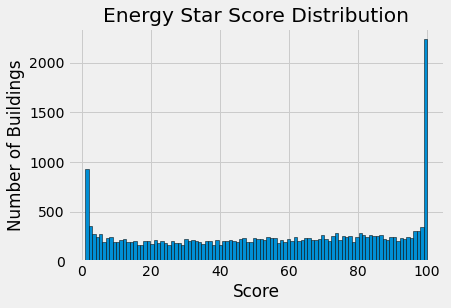

In [65]:
# Исследуем целевую переменную
# Histogram of the Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(data['ENERGY STAR Score'].dropna(), bins = 100, edgecolor = 'k')
plt.xlabel('Score')
plt.ylabel('Number of Buildings')
plt.title('Energy Star Score Distribution')

У баллов подозрительное распределение: слишком много зданий набрало скор в 100% по сравнению с общим распределением. 
Этот балл рассчитывается на основе самостоятельно заполняемых владельцами зданий отчётов, что может объяснить избыток очень больших значений. Поэтому это не самый объективный критерий оценки энергоэффективности недвижимости.

In [75]:
for b_type in types:
    # Select the building type
    subset = data[data['Largest Property Use Type'] == b_type]
subset['Largest Property Use Type']

5        Worship Facility
219      Worship Facility
335      Worship Facility
536      Worship Facility
971      Worship Facility
               ...       
33164    Worship Facility
33368    Worship Facility
33779    Worship Facility
33784    Worship Facility
33835    Worship Facility
Name: Largest Property Use Type, Length: 161, dtype: object

Text(0.5, 1.0, 'Density Plot of Energy Star Scores by Building Type')

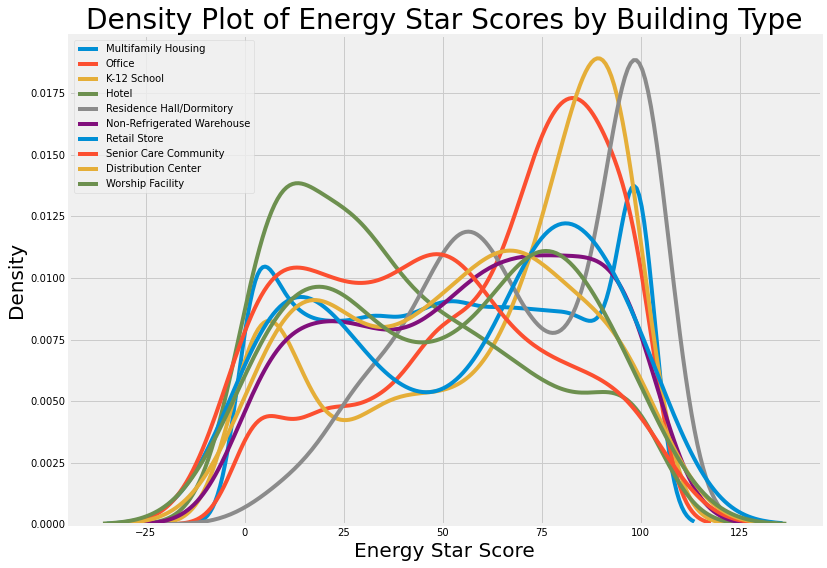

In [83]:
# Create a list of buildings with more than 100 measurements
types = data.dropna(subset=['ENERGY STAR Score'])
types = types['Largest Property Use Type'].value_counts()
types = list(types[types.values > 100].index)

# Plot of distribution of scores for building categories
plt.figure(figsize=(12,9))

# Plot each building
for b_type in types:
    # Select the building type
    subset = data[data['Largest Property Use Type'] == b_type]
    
    # Density plot of Energy Star Scores
    sns.kdeplot(subset['ENERGY STAR Score'].dropna(),
               label = b_type, shade = False, alpha = 0.8)
plt.legend()   
# label the plot
plt.xlabel('Energy Star Score', size = 20); plt.ylabel('Density', size = 20)
plt.title('Density Plot of Energy Star Scores by Building Type', size = 28)

Тип здания сильно влияет на количество баллов. Значит, надо включить его в модель.

Text(0.5, 1.0, 'Density Plot of Energy Star Scores by Borough')

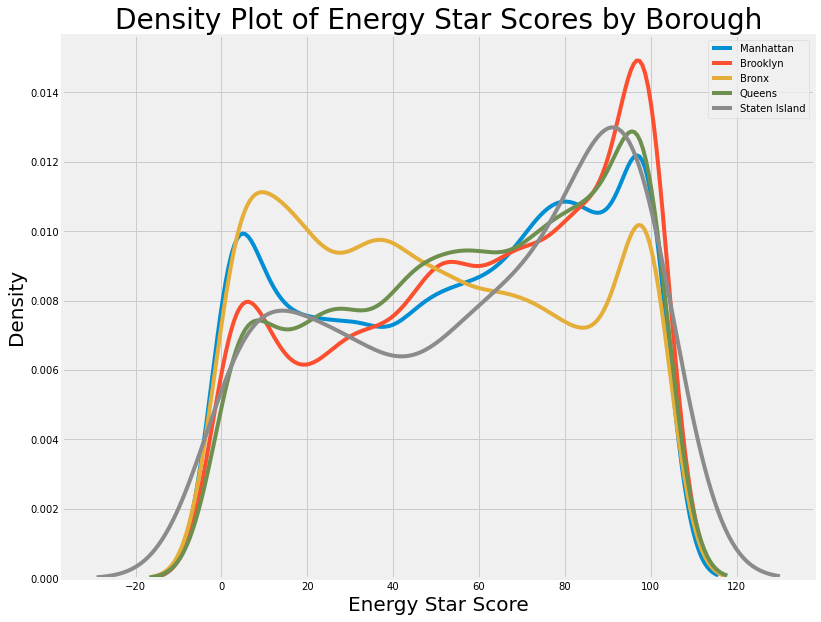

In [92]:
# Create a list of boroughs with more than 100 observations
boroughs = data.dropna(subset=['ENERGY STAR Score'])
boroughs = boroughs['Borough'].value_counts()
boroughs = list(boroughs[boroughs.values > 100].index)

# Plot of distribution of scores for boroughs
plt.figure(figsize=(12, 10))

# Plot each borough distribution of scores
for borough in boroughs:
    # Select the building type
    subset = data[data['Borough'] == borough]
    
    # Density plot of Energy Star scores
    sns.kdeplot(subset['ENERGY STAR Score'].dropna(),
               label = borough);
plt.legend()   
# label the plot
plt.xlabel('Energy Star Score', size = 20); plt.ylabel('Density', size = 20)
plt.title('Density Plot of Energy Star Scores by Borough', size = 28)

Район не так сильно влияет на балл, как тип здания. Тем не менее мы включим его в модель, потому что между районами существует небольшая разница.

In [94]:
# Find all correlations with the score and sort 
correlations_data = data.corr()['ENERGY STAR Score'].sort_values()
correlations_data

Site EUI (kBtu/ft²)                                          -0.764947
Weather Normalized Site EUI (kBtu/ft²)                       -0.759865
Weather Normalized Source EUI (kBtu/ft²)                     -0.676350
Source EUI (kBtu/ft²)                                        -0.664716
Weather Normalized Site Natural Gas Intensity (therms/ft²)   -0.477838
Weather Normalized Site Electricity Intensity (kWh/ft²)      -0.349015
Property Id                                                  -0.138856
Order                                                        -0.098902
Direct GHG Emissions (Metric Tons CO2e)                      -0.094196
Weather Normalized Site Natural Gas Use (therms)             -0.080714
Natural Gas Use (kBtu)                                       -0.079888
Total GHG Emissions (Metric Tons CO2e)                       -0.068426
Occupancy                                                    -0.048963
Electricity Use - Grid Purchase (kWh)                        -0.018676
Electr

Чтобы выявить возможные нелинейные взаимосвязи, возьмем квадратный корень и натуральный логарифм от признаков и посчитаем корреляцию с energy star score.

Чтобы посмотреть на зависимости между городами/ типами зданий и score-рейтингом, применим one-hot encode к этим колонкам.

In [95]:
# Select the numeric columns
numeric_subset = data.select_dtypes('number')

# Create columns with square root and log of numeric columns
for col in numeric_subset.columns:
    # Skip the Energy Star Score column
    if col == 'ENERGY STAR Score':
        next
    else:
        numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
        numeric_subset['log_' + col] = np.log(numeric_subset[col])

# Select the categorical columns
categorical_subset = data[['Borough', 'Largest Property Use Type']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Drop buildings without an energy star score
features = features.dropna(subset = ['ENERGY STAR Score'])

# Find correlations with the score 
correlations = features.corr()['ENERGY STAR Score'].dropna().sort_values()

<ipython-input-95-0bece1c24901>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
<ipython-input-95-0bece1c24901>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_subset['log_' + col] = np.log(numeric_subset[col])
E:\Anaconda\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\Anaconda\lib\site-packages\pandas\core\series.py:726: RuntimeWarn

In [98]:
correlations

Site EUI (kBtu/ft²)                                       -0.764947
Weather Normalized Site EUI (kBtu/ft²)                    -0.759865
sqrt_Site EUI (kBtu/ft²)                                  -0.754405
sqrt_Weather Normalized Site EUI (kBtu/ft²)               -0.748839
sqrt_Weather Normalized Source EUI (kBtu/ft²)             -0.716912
                                                             ...   
sqrt_Self-Reported Gross Floor Area (ft²)                  0.104654
sqrt_Largest Property Use Type - Gross Floor Area (ft²)    0.108566
log_Self-Reported Gross Floor Area (ft²)                   0.133142
log_Largest Property Use Type - Gross Floor Area (ft²)     0.136875
ENERGY STAR Score                                          1.000000
Name: ENERGY STAR Score, Length: 104, dtype: float64

Сильнейшая взаимосвязь все еще с Energy Use Intensity (EUI). Нет сильной положительной линейной связи, хотя видно, что тип здания положительно коррелирует со скором.

#### Двухпеременные графики

Чтобы визуализировать взаимосвязь  между 2 переменными, изобразим скаттерплот.

E:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
E:\Anaconda\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Energy Star Score vs Site EUI')

<Figure size 864x720 with 0 Axes>

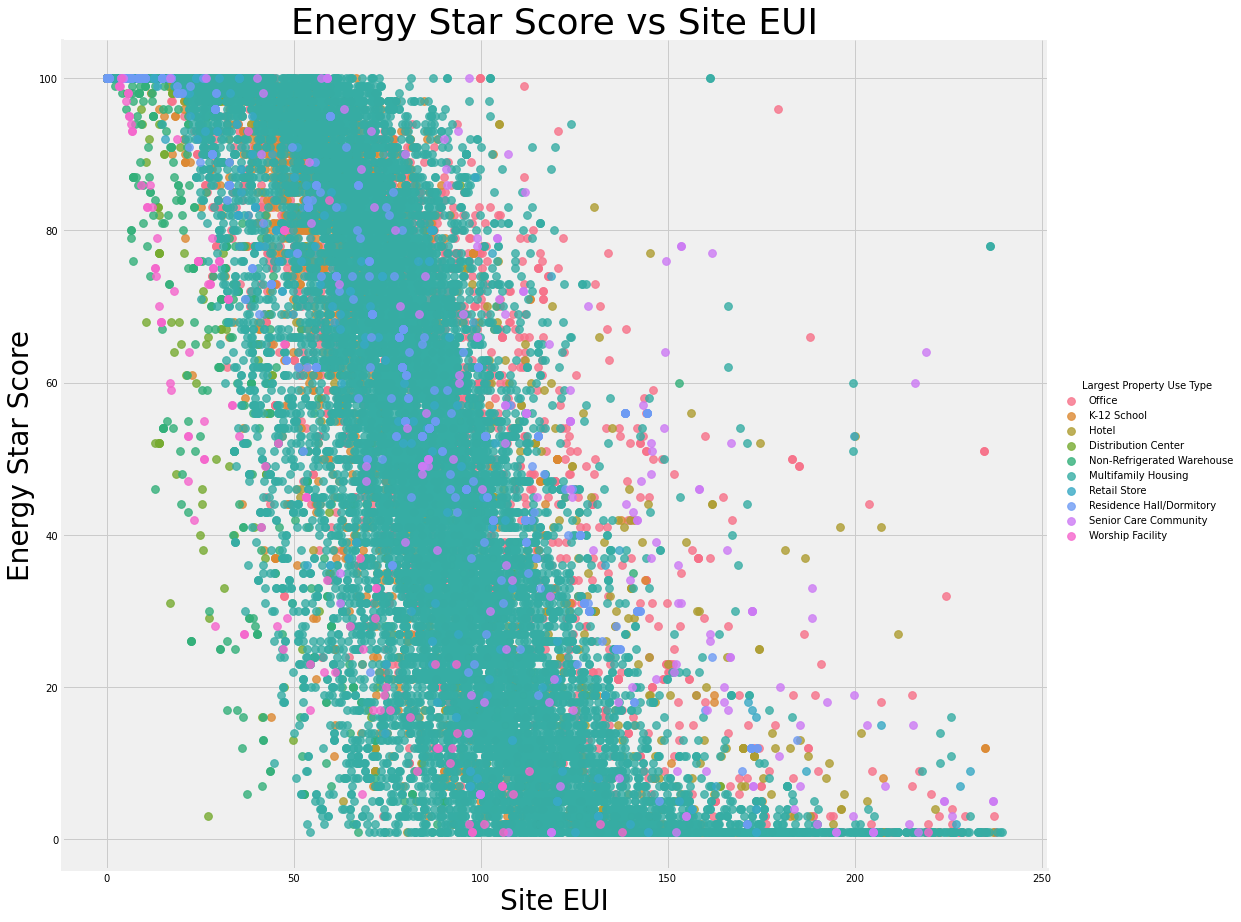

In [104]:
plt.figure(figsize=(12, 10))

# Extract the building types
features['Largest Property Use Type'] = data.dropna(subset = ['ENERGY STAR Score'])['Largest Property Use Type']

# Limit to building types with more than 100 observations (from previous code)
features = features[features['Largest Property Use Type'].isin(types)]

# Use seaborn to plot a scatterplot of Score vs Log Source EUI
sns.lmplot('Site EUI (kBtu/ft²)', 'ENERGY STAR Score', 
          hue = 'Largest Property Use Type', data = features,
          scatter_kws = {'alpha': 0.8, 's': 60}, fit_reg = False,
          size = 12, aspect = 1.2);

# Plot labeling
plt.xlabel("Site EUI", size = 28)
plt.ylabel('Energy Star Score', size = 28)
plt.title('Energy Star Score vs Site EUI', size = 36)

По мере уменьшения EUI увеличивается Energy Star Score, эта взаимосвязь наблюдается у зданий разных типов.

In [ ]:
# Extract the columns to plot
plot_data = features[['ENERGY STAR Score', 'Site EUI (kBtu/ft²)', 
                      'Weather Normalized Source EUI (kBtu/ft²)', 
                      'log_Total GHG Emissions (Metric Tons CO2e)']]

# Replace the inf with nan
plot_data = plot_data.replace({np.inf: np.nan, -np.inf: np.nan})

# Rename columns 
plot_data = plot_data.rename(columns = {'Site EUI (kBtu/ft²)': 'Site EUI', 
                                        'Weather Normalized Source EUI (kBtu/ft²)': 'Weather Norm EUI',
                                        'log_Total GHG Emissions (Metric Tons CO2e)': 'log GHG Emissions'})

# Drop na values
plot_data = plot_data.dropna()

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3)

# Upper is a scatter plot
grid.map_upper(plt.scatter, color = 'red', alpha = 0.6)

# Diagonal is a histogram
grid.map_diag(plt.hist, color = 'red', edgecolor = 'black')

# Bottom is correlation and density plot
grid.map_lower(corr_func);
grid.map_lower(sns.kdeplot, cmap = plt.cm.Reds)

# Title for entire plot
plt.suptitle('Pairs Plot of Energy Data', size = 36, y = 1.02)

### Конструирование и выбор признаков

Применим к категориальным переменным (квартал и тип собственности) one-hot кодирование.
Добавим взятие натурального логарифма от всех числовых переменных.

In [113]:
# Copy the original data
features = data.copy()

# Select the numeric columns
numeric_subset = data.select_dtypes('number')

# Create columns with log of numeric columns
for col in numeric_subset.columns:
    # Skip the Energy Star Score column
    if col == 'ENERGY STAR Score':
        next
    else:
        numeric_subset['log_' + col] = np.log(numeric_subset[col])
        
# Select the categorical columns
categorical_subset = data[['Borough', 'Largest Property Use Type']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

<ipython-input-113-b9862436f800>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_subset['log_' + col] = np.log(numeric_subset[col])


Многие из имеющихся 110 признаков избыточны, потому что сильно коррелируют друг с другом. 

Text(0.5, 1.0, 'Weather Norm EUI vs Site EUI, R = 0.9979')

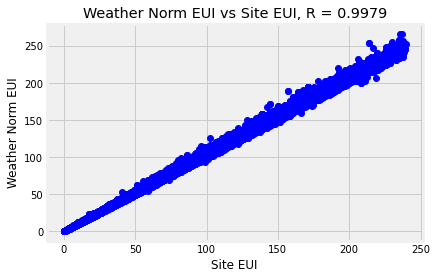

In [129]:
plot_data = data[['Weather Normalized Site EUI (kBtu/ft²)', 'Site EUI (kBtu/ft²)']].dropna()

plt.plot(plot_data['Site EUI (kBtu/ft²)'], plot_data['Weather Normalized Site EUI (kBtu/ft²)'], 'bo')
plt.xlabel('Site EUI')
plt.ylabel('Weather Norm EUI')
plt.title('Weather Norm EUI vs Site EUI, R = %0.4f' % np.corrcoef(
    data[['Weather Normalized Site EUI (kBtu/ft²)', 'Site EUI (kBtu/ft²)']].dropna(), rowvar=False)[0][1])

Признаки, которые сильно коррелируют друг с другом, называются коллинеарными. Удаление одной переменной в таких парах признаков часто помогает модели обобщать и быть более интерпретируемой. 
Существует ряд методов вычисления коллинеарности признаков, и один из самых популярных — фактор увеличения дисперсии (variance inflation factor). Мы для поиска и удаления коллинеарных признаков воспользуемся коэффициентом В-корреляции (thebcorrelation coefficient). Отбросим одну пару признаков, если коэффициент корреляции между ними больше 0,6. 
Код с https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on/43104383#43104383

In [137]:
# Remove any columns with all na values
features  = features.dropna(axis=1, how = 'all')
features.shape

(31104, 126)

Выберем исходный базовый уровень — некое предположение, с которым мы будем сравнивать результаты работы моделей. Если они окажутся ниже базового уровня, мы будем считать, что машинное обучение неприменимо для решения этой задачи, или что нужно попробовать иной подход.

Для регрессионных задач в качестве базового уровня разумно угадывать медианное значение цели на обучающем наборе для всех примеров в тестовом наборе. Эти наборы задают барьер, относительно низкий для любой модели.

В качестве метрики возьмём среднюю абсолютную ошибку (mae) в прогнозах. Нужно разбить данные на обучающий и тестовый наборы 70 на 30.

In [143]:
# Extract the buildings with no score and the buildings with a score
no_score = features[features['ENERGY STAR Score'].isna()]
score = features[features['ENERGY STAR Score'].notnull()]

print(no_score.shape)
print(score.shape)

(6130, 126)
(24974, 126)


In [144]:
# Separate out the features and targets
features = score.drop(columns='ENERGY STAR Score')
targets = pd.DataFrame(score['ENERGY STAR Score'])

# Replace the inf and -inf with nan (required for later imputation)
features = features.replace({np.inf: np.nan, -np.inf: np.nan})

# Split into 70% training and 30% testing set
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(17481, 125)
(7493, 125)
(17481, 1)
(7493, 1)


In [145]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

baseline_guess = np.median(y)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, baseline_guess))

The baseline guess is a score of 57.00
Baseline Performance on the test set: MAE = 27.9674


Средняя абсолютная ошибка на тестовом наборе составила около 28 %. Это довольно низко.

### Оценка и выбор модели

Обычно рекомендуется начинать с простых, интерпретируемых моделей, таких как линейная регрессия, и если результаты будут неудовлетворительными, то переходить к более сложным, но обычно более точным методам. 
Мы будем оценивать пять моделей разной степени сложности:

* Линейная регрессия
* Метод k-ближайших соседей
* «Случайный лес»
* Градиентный бустинг
* Метод опорных векторов

In [148]:
# Imputing missing values and scaling values
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [154]:
train_features = X
test_features = X_test
train_labels = y
test_labels = y_test

Заполним отсутствующие значения

In [155]:
# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')
# Train on the training features
imputer.fit(train_features)
# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

### Масштабирование признаков 
Это необходимый шаг, потому что признаки измеряются в разных единицах, а значит покрывают разные диапазоны. Это сильно искажает результаты таких алгоритмов, как метод опорных векторов и метод k-ближайших соседей, которые учитывают расстояния между измерениями. А масштабирование позволяет этого избежать. И хотя методы вроде линейной регрессии и «случайного леса» не требует масштабирования признаков, лучше не пренебрегать этим этапом при сравнении нескольких алгоритмов.

Масштабировать будем с помощью приведения каждого признака к диапазону от 0 до 1. Берём все значения признака, выбираем минимальное и делим его на разницу между максимальным и минимальным (диапазон). Такой способ масштабирования часто называют нормализацией, а другой основной способ — стандартизацией.

Этот процесс легко реализовать вручную, поэтому воспользуемся объектом MinMaxScaler из Scikit-Learn. Код для этого метода идентичен коду для заполнения отсутствующих значений, только вместо вставки применяется масштабирование.

In [159]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit on the training data
scaler.fit(X)
# Transform both the training and testing data
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [181]:
# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

In [182]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

In [183]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MAE = 14.0468


In [184]:
svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % svm_mae)

Support Vector Machine Regression Performance on the test set: MAE = 9.6823


In [185]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)

Random Forest Regression Performance on the test set: MAE = 7.0160


In [186]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 9.2736


In [187]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 11.4143


Text(0.5, 1.0, 'Model Comparison on Test MAE')

<Figure size 576x432 with 0 Axes>

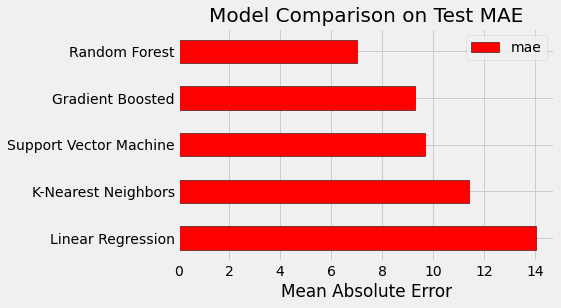

In [189]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 6))

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [lr_mae, svm_mae, random_forest_mae, 
                                         gradient_boosted_mae, knn_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20)

На графике видно, что случайный лес показал наименьшую ошибку, линейная регрессия - наибольшую.
Хотя эти результаты нельзя считать абсолютно честными, потому что для гиперпараметров мы по большей части используем значения по умолчанию. Эффективность моделей сильно зависит от этих настроек, особенно в методе опорных векторов. Тем не менее на основании этих результатов мы выберем градиентный бустинг и станем его оптимизировать.

### Гиперпараметрическая оптимизация модели

##### Случайный поиск и кросс-валидация
*Случайный поиск - определяем сетку, а потом из неё случайно выбираем различные комбинации, в отличие от сеточного поиска (grid search), при котором мы последовательно пробуем каждую комбинацию.Случайный поиск работает почти так же хорошо, как и сеточный, но гораздо быстрее*
* Задаём сетку гиперпараметров.
* Случайно выбираем комбинацию гиперпараметров.
* Создаём модель с использованием этой комбинации.
* Оцениваем результат работы модели с помощью k-блочной перекрёстной проверки.
* Решаем, какие гиперпараметры дают лучший результат.

Будем использовать регрессионную модель на основе градиентного бустинга. Это сборный метод, то есть модель состоит из многочисленных «слабых учеников» (weak learners), в данном случае из отдельных деревьев решений (decision trees). Если в пакетных алгоритмах вроде «случайного леса» ученики обучаются параллельно, а затем методом голосования выбирается результат прогнозирования, то в boosting-алгоритмах вроде градиентного бустинга ученики обучаются последовательно, и каждый из них «сосредотачивается» на ошибках, сделанных предшественниками.

Градиентный бустинг — одна из реализаций, в которой для минимизации стоимости функции применяется градиентный спуск (Gradient Descent). Реализация градиентного бустинга в Scikit-Learn считается не такой эффективной, как в других библиотеках, например, в XGBoost, но она неплохо работает на маленьких датасетах и выдаёт достаточно точные прогнозы.

В коде ниже создаётся сетка из гиперпараметров, затем объект RandomizedSearchCV и ищется с помощью 4-блочной перекрёстной проверки по 25 разным комбинациям гиперпараметров:

In [192]:
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'max_features': max_features}

In [194]:
# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state = 42)

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
    param_distributions=hyperparameter_grid,
    cv=4, n_iter=25, 
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1, verbose = 1, 
    return_train_score = True,
    random_state=42)

In [197]:
# Fit on the training data
%time
random_cv.fit(X, y)

Wall time: 0 ns
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 43.0min finished


RandomizedSearchCV(cv=4, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'loss': ['ls', 'lad', 'huber'],
                                        'max_depth': [2, 3, 5, 10, 15],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 4, 6, 10],
                                        'n_estimators': [100, 500, 900, 1100,
                                                         1500]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=1)

In [199]:
# Find the best combination of settings
random_cv.best_estimator_

GradientBoostingRegressor(loss='huber', max_depth=10, min_samples_leaf=6,
                          min_samples_split=10, n_estimators=1100,
                          random_state=42)

Эти результаты можно использовать для сеточного поиска, выбирая для сетки параметры, которые близки к этим оптимальным значениям. 
Для изменения количества оценщиков деревьев решений с сохранением значений других гиперпараметров можно поставить один эксперимент, который продемонстрирует роль этой настройки.

In [201]:
# Create a range of trees to evaluate
trees_grid = {'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]}

model = GradientBoostingRegressor(loss = 'huber', max_depth = 10,
                                  min_samples_leaf = 6,
                                  min_samples_split = 10,
                                  max_features = None,
                                  random_state = 42)

# Grid Search Object using the trees range and the random forest model
grid_search = GridSearchCV(estimator = model, param_grid=trees_grid, cv = 4, 
                           scoring = 'neg_mean_absolute_error', verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [203]:
# Fit the grid search
grid_search.fit(X, y)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 43.3min finished


GridSearchCV(cv=4,
             estimator=GradientBoostingRegressor(loss='huber', max_depth=10,
                                                 min_samples_leaf=6,
                                                 min_samples_split=10,
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'n_estimators': [100, 150, 200, 250, 300, 350, 400,
                                          450, 500, 550, 600, 650, 700, 750,
                                          800]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

Text(0.5, 1.0, 'Performance vs Number of Trees')

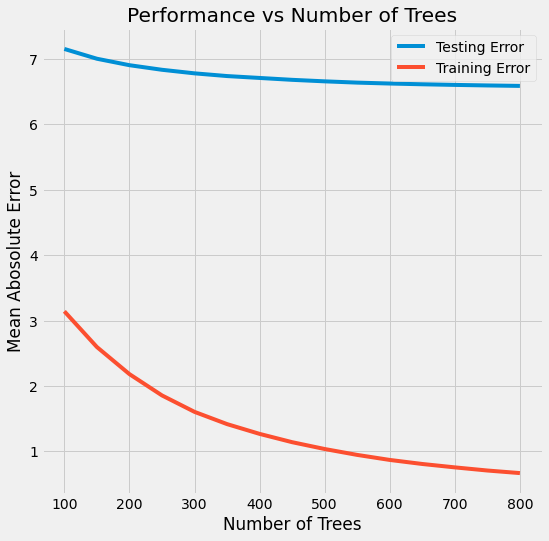

In [206]:
# Get the results into a dataframe
results = pd.DataFrame(grid_search.cv_results_)

# Plot the training and testing error vs number of trees
plt.figure(figsize=(8, 8))
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees'); plt.ylabel('Mean Abosolute Error')
plt.legend()
plt.title('Performance vs Number of Trees')

С ростом количества используемых моделью деревьев снижается уровень ошибок в ходе обучения и тестирования. Но ошибки при обучении снижаются куда быстрее, и в результате модель переобучается.

На тестовых данных точность всегда снижается, но существенное падение говорит о переобучении. Решить эту проблему можно с помощью увеличения объёма обучающих данных или уменьшения сложности модели с помощью гиперпараметров.

Для нашей финальной модели мы возьмём 1100 оценщиков, потому что это даст нам самый низкий уровень ошибки при перекрёстной проверке.

### Оценка лучшей модели на тестовом наборе данных

In [209]:
# Default model
default_model = GradientBoostingRegressor(random_state = 42)

# Select the best model
final_model = grid_search.best_estimator_
final_model

GradientBoostingRegressor(loss='huber', max_depth=10, min_samples_leaf=6,
                          min_samples_split=10, n_estimators=800,
                          random_state=42)

Гиперпараметрическая настройка помогла улучшить точность модели примерно на 10 %. В зависимости от ситуации это может быть очень значительное улучшение, но требующее немало времени.

Сравним длительность обучения обеих моделей с %timeit. Сначала измерим длительность работы модели по умолчанию:

In [210]:
%%timeit -n 1 -r 5
default_model.fit(X, y)

15.8 s ± 297 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [211]:
%%timeit -n 1 -r 5
final_model.fit(X, y)

6min 49s ± 7.86 s per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [212]:
# Make predictions on the test set using default and final model
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)
print('Default model performance on the test set: MAE = %0.4f.' % mae(y_test, default_pred))
print('Final model performance on the test set:   MAE = %0.4f.' % mae(y_test, final_pred))

Default model performance on the test set: MAE = 9.2736.
Final model performance on the test set:   MAE = 6.2480.


Окончательная модель превосходит базовую модель примерно на 33%, но за счет значительного увеличения времени работы. Машинное обучение часто является полем компромиссов: смещение против дисперсии, точность против интерпретируемости, точность против времени выполнения и окончательное решение о том, какую модель использовать, зависит от ситуации. Здесь увеличение времени выполнения не является препятствием, потому что, хотя относительная разница велика, абсолютная величина времени обучения не имеет значения.

Мы получили финальные результаты прогнозирования, теперь проанализируем их и выясним, есть ли какие-то заметные отклонения.

Text(0.5, 1.0, 'Test Values and Predictions')

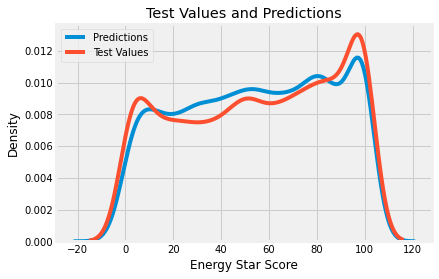

In [240]:
# Density plot of the final predictions and the test values

sns.kdeplot(final_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Test Values')

# Label the plot
plt.legend()
plt.xlabel('Energy Star Score')
plt.ylabel('Density')
plt.title('Test Values and Predictions')

Text(0.5, 1.0, 'Distribution of Residuals')

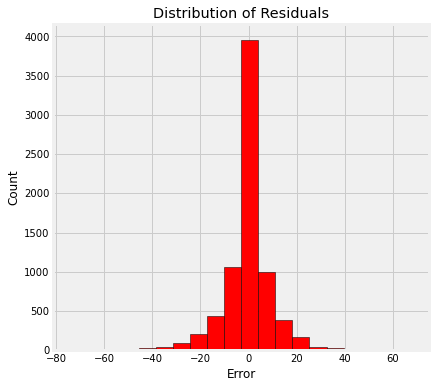

In [237]:
plt.figure(figsize = (6, 6))

# Calculate the residuals 
residuals = final_pred - y_test

# Plot the residuals in a histogram
plt.hist(residuals, color = 'red', bins = 20,
         edgecolor = 'black')
plt.xlabel('Error'); plt.ylabel('Count')
plt.title('Distribution of Residuals')

Прогноз модели неплохо повторяет распределение реальных значений, на обучающих данных пик плотности практически схож с реальным (около 100). Погрешности имеют почти нормальное распределение. 

Результаты свидетельствуют, что мы можем применять машинное обучение для прогнозирования баллов Energy Star Score на основе доступной статистики. С помощью градиентного бустинга удалось на тестовых данных добиться погрешности в пределах 6,3. Гиперпараметрическая настройка может сильно улучшить результаты, но ценой значительного замедления работы. Это один из многих компромиссов, которые нужно учитывать в машинном обучении.

In [242]:
model

GradientBoostingRegressor(loss='huber', max_depth=10, min_samples_leaf=6,
                          min_samples_split=10, random_state=42)

### Интерпретация модели

In [245]:
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Set default font size
plt.rcParams['font.size'] = 24

# LIME for explaining predictions
import lime 
import lime.lime_tabular

### Важности признаков

In [247]:
model.fit(X,y)

GradientBoostingRegressor(loss='huber', max_depth=10, min_samples_leaf=6,
                          min_samples_split=10, random_state=42)

In [248]:
#  Make predictions on the test set
model_pred = model.predict(X_test)

print('Final Model Performance on the test set: MAE = %0.4f' % mae(y_test, model_pred))

Final Model Performance on the test set: MAE = 6.9780


In [249]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(train_features.columns), 
                                'importance': model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,Source EUI (kBtu/ft²),0.623980
1,log_Site EUI (kBtu/ft²),0.072573
2,Site EUI (kBtu/ft²),0.046887
3,Largest Property Use Type_Office,0.033138
4,log_Source EUI (kBtu/ft²),0.026700
5,Order,0.026662
6,log_Order,0.018757
7,Largest Property Use Type_Multifamily Housing,0.016890
8,Property Id,0.009636
9,Largest Property Use Type_Non-Refrigerated War...,0.009259


<Figure size 864x720 with 0 Axes>

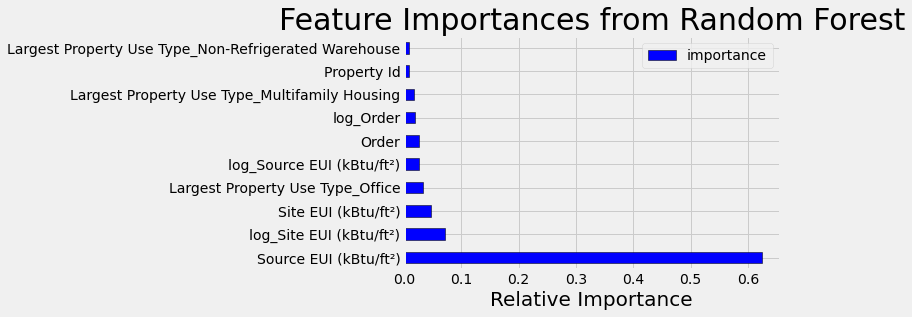

In [251]:
plt.figure(figsize=(12, 10))
plt.style.use('fivethirtyeight')

# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 30);

Самый важный признак — Site EUI (интенсивность потребления энергии). Уже у второго признака важность сильно падает, это может говорить о том, что нам не нужно использовать все 64 признака для достижения высокой точности прогнозирования.

In [253]:
# Extract the names of the most important features
most_important_features = feature_results['feature'][:10]

# Find the index that corresponds to each feature name
indices = [list(train_features.columns).index(x) for x in most_important_features]

# Keep only the most important features
X_reduced = X[:, indices]
X_test_reduced = X_test[:, indices]

print('Most important training features shape: ', X_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (17481, 10)
Most important testing  features shape:  (7493, 10)


In [254]:
lr = LinearRegression()

# Fit on full set of features
lr.fit(X, y)
lr_full_pred = lr.predict(X_test)

# Fit on reduced set of features
lr.fit(X_reduced, y)
lr_reduced_pred = lr.predict(X_test_reduced)

# Display results
print('Linear Regression Full Results: MAE =    %0.4f.' % mae(y_test, lr_full_pred))
print('Linear Regression Reduced Results: MAE = %0.4f.' % mae(y_test, lr_reduced_pred))

Linear Regression Full Results: MAE =    14.0468.
Linear Regression Reduced Results: MAE = 15.0384.


Дополнительная информация в признаках с низкой важностью действительно улучшает производительность.

Как сокращенный набор признаков сказывается на производительности в градиентном бустинге? 

In [255]:
# Create the model with the same hyperparamters
model_reduced = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

# Fit and test on the reduced set of features
model_reduced.fit(X_reduced, y)
model_reduced_pred = model_reduced.predict(X_test_reduced)

print('Gradient Boosted Reduced Results: MAE = %0.4f' % mae(y_test, model_reduced_pred))

Gradient Boosted Reduced Results: MAE = 8.6770


Результаты модели немного хуже. Модель, в которой используется меньше фичей, будет быстрее обучаться и, как правило, ее легче интерпретировать.

In [256]:
# Find the residuals
residuals = abs(model_reduced_pred - y_test)
    
# Exact the worst and best prediction
wrong = X_test_reduced[np.argmax(residuals), :]
right = X_test_reduced[np.argmin(residuals), :]

In [257]:
# Create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_reduced, 
                                                   mode = 'regression',
                                                   training_labels = y,
                                                   feature_names = list(most_important_features))

Prediction: 1.1953
Actual Value: 100.0000


Text(0.5, 0, 'Effect on Prediction')

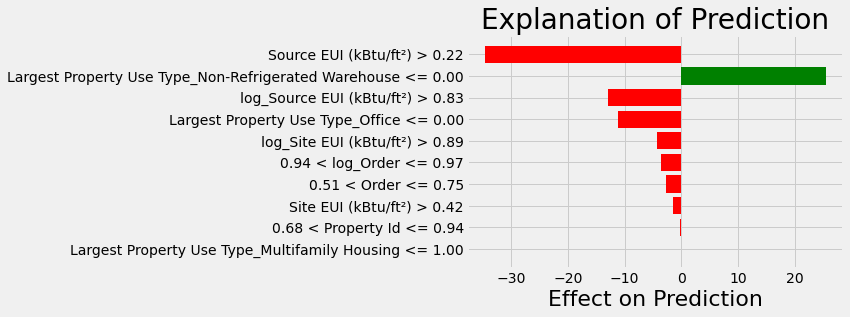

In [259]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(wrong.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmax(residuals)])

# Explanation for wrong prediction
wrong_exp = explainer.explain_instance(data_row = wrong, 
                                       predict_fn = model_reduced.predict)

# Plot the prediction explaination
wrong_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28)
plt.xlabel('Effect on Prediction', size = 22)

В этом примере наша модель с градиентным бустингом предсказала оценку 1.20, а фактическое значение - 100.
График показывает влияние каждой фичи на прогноз (как факторный анализ).Мы видим, что EUI сайта значительно снизила прогноз, потому что он был выше 0,22. С другой стороны, Weather Normalized Site Electricity Intensity увеличила прогноз.

Теперь мы можем проделать тот же процесс с предсказанием, которое получилось в модели.

Prediction: 100.0000
Actual Value: 100.0000


Text(0.5, 0, 'Effect on Prediction')

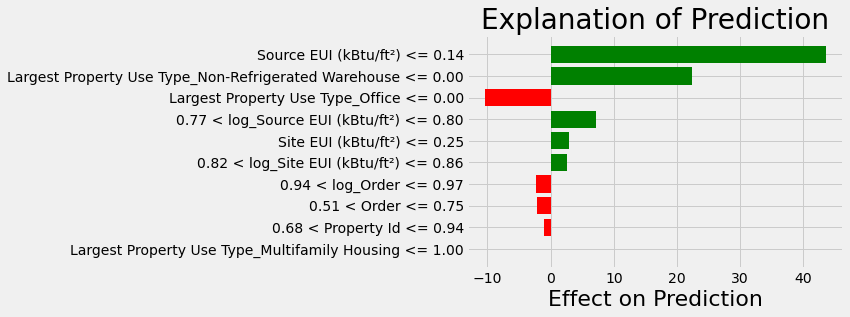

In [260]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(right.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmin(residuals)])

# Explanation for wrong prediction
right_exp = explainer.explain_instance(right, model_reduced.predict, num_features=10)
right_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28)
plt.xlabel('Effect on Prediction', size = 22)

### Визуализация одного дерева решений

In [262]:
from sklearn import tree

# Extract a single tree
single_tree = model_reduced.estimators_[105][0]

tree.export_graphviz(single_tree, out_file = 'E:/tree.dot',
                     rounded = True, 
                     feature_names = most_important_features,
                     filled = True)

single_tree

DecisionTreeRegressor(criterion='friedman_mse', max_depth=5, min_samples_leaf=6,
                      min_samples_split=6,
                      random_state=RandomState(MT19937) at 0x207FA040)

In [271]:
import pydot

(graph, ) = pydot.graph_from_dot_file('E:/tree.dot')
graph.write_png('E:/tree.png')

Каждый узел (прямоугольник) дерева содержит четыре строки:

* Задаваемый вопрос о значении одного из признаков конкретного измерения: от него зависит, в какую сторону мы выйдем из этого узла.
* Mse — мера ошибки в узле.
* Samples — количество образцов данных (измерений) в узле.
* Value — оценка цели для всех образцов данных в узле.

### Выводы

* Используя данные об энергопотреблении здания, модель машинного обучения может прогнозировать показатель Energy Star Score с точностью до 10 баллов.
* Наиболее важной переменной для определения рейтинга Energy Star Score является Source EUI интенсивность использования энергии.